In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import dill
import pandas as pd
from scipy import optimize as opt
from sklearn.preprocessing import MinMaxScaler
import time
import sys
sys.path.append('../../')
import src
from numba import njit


np.random.seed(383461)
#GMM parameters
maxiters = 100 #100, 8.6 minutos por iteración para differential_evolution
time_periods = 40 #Maximum spell_t to consider
max_t_to_consider = 37
min_periods = 3 #Min window period for standard deviation
use_logs_for_x = False
simul_repetitions = 1 #simulation repetitions
method = "mixed"  #"differential evolution", "Nelder-Mead", "mixed"
print(f"""Started at {time.asctime()}. Discount: {src.const.δ}.
          Method {method} with {maxiters} maxiters. Logs for x? {use_logs_for_x}""")


#Load policy and value function
#####################

#file_n = "2019-4-12medium_prod_vfi_dict.dill"
file_n = "2019-4-27medium_prod_vfi_dict.dill" #discount 0.95 (I think)
#file_n = "2019-4-28medium_prod_vfi_dict.dill" #discount 0.99 (I think)
#file_n = "" #Work Macbook
with open('../../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)


#dataframe and standard deviation
cleaned_data = "../../../firm_learning/data/cleaned_data/"

df = pd.read_csv(cleaned_data + "medium_prod_for_gmm.csv")
std_devs = (df.groupby('firm').level_prices.rolling(window=4, min=min_periods)
            .std().reset_index()
            .rename(columns={'level_1': 't', 'level_prices': 'std_dev_prices'}))

df = pd.merge(df, std_devs, on=['firm', 't'], how='left')
df["dmd_shocks"] = np.random.normal(loc=0, scale=src.const.σ_ɛ, size=len(df))

n_firms = df.firm.nunique()
max_t_periods_in_data = df.groupby('firm').log_dmd.count().max()


def param_array_to_dmd_constants(Ξ):
    return {'γ': Ξ[0],  'beta_shock_std': Ξ[1], 'taste_shock_std': Ξ[2]}


mean_std_observed_prices = df.groupby('t').rolling_std_upc.mean()[min_periods:]

#Mix Max scaling for xs
if use_logs_for_x:
    xs = np.log(df.groupby('firm').xs.first().values + 0.1)
else:
    xs = (df.groupby('firm').xs.first().values + 0.1)
scaler = MinMaxScaler()
xs = scaler.fit_transform(xs.reshape(-1, 1)).flatten()

Nfirms = len(xs)


@njit()
def inner_loop_with_numba_unbalanced(simul_repetitions_, firm_lengths: np.array, n_firms: int, len_df: int, γ,
                                     taste_shocks, b0):
    betas_inertia_by_m = np.empty((len_df, simul_repetitions_))
    for m in range(simul_repetitions):
        for i_firm in range(n_firms):
            betas_inertia_by_m[firm_lengths[i_firm]:firm_lengths[i_firm + 1], m] = \
                (src.generate_betas_inertia_Ξ(γ, taste_shocks, b0,
                                              firm_lengths[i_firm + 1] - firm_lengths[i_firm],
                                              i_firm))
    return betas_inertia_by_m


#Draw shocks
#################
prior_shocks = src.gen_prior_shocks(Nfirms, σerror=0) # Add zeroes for the gmm estimation
taste_std_normal_shocks = np.random.normal(loc=0, scale=1, size=(max_t_periods_in_data, n_firms))
b0_std_normal_shocks = np.random.normal(loc=0, scale=1, size=n_firms)



def full_gmm_error(θandΞ: np.array, policyF: object, xs: np.array, mean_std_observed_prices: pd.Series,
                   prior_shocks: np.array, df: pd.DataFrame, len_df, firm_lengths,
                   min_periods: int = 3, w=None) -> float:
    """
    Computes the gmm error of the different between the observed moments and
    the moments predicted by the model + θ

    Moments: average (over firms) standard deviation for each time period

    xs: characteristics of firms
    mean_std_observed_prices: mean (over firms) of standard deviation per t
    w: weighting matrix for GMM objective
    """
    np.random.seed(383461)

    θ = θandΞ[:4]
    Ξ = θandΞ[4::]

    lambdas0 = src.from_theta_to_lambda_for_all_firms(θ, xs, prior_shocks)

    dmd_const_dict = param_array_to_dmd_constants(Ξ)
    γ, beta_shock_std = dmd_const_dict['γ'], dmd_const_dict['beta_shock_std']
    taste_shock_std = dmd_const_dict['taste_shock_std']

    # Redo taste_shocks and b0
    taste_shocks_ = taste_std_normal_shocks*taste_shock_std
    b0_ = np.clip(src.const.mature_beta + beta_shock_std*b0_std_normal_shocks, -np.inf, -1.05)



    exp_prices = []
    #TODO: NOW definitely numba this loop!!!
    #df["betas_inertia"] = 0.
    #for m in range(simul_repetitions):
    #    for i_firm, firm in enumerate(df.firm.unique()):
    #        mask: pd.Series = (df.firm == firm)
    #        t = mask.sum()
    #        df.loc[mask, "betas_inertia"] = src.generate_betas_inertia_Ξ(γ, taste_shocks_,
    #                                                                 b0_, t, i_firm)
    m_betas_inertia = inner_loop_with_numba_unbalanced(simul_repetitions, firm_lengths,
                                                      n_firms, len_df, γ,
                                                      taste_shocks_, b0_)

    for m in range(simul_repetitions):
        df['betas_inertia'] = m_betas_inertia[:, m]
        mean_std_observed_prices_clean, mean_std_expected_prices = src.get_intersection_of_observed_and_expected_prices(
                                    mean_std_observed_prices, df, policyF, lambdas0, min_periods)
        exp_prices.append(mean_std_expected_prices)

    try:
        assert len(mean_std_observed_prices_clean) == len(mean_std_expected_prices)
    except AssertionError as e:
        e.args += (len(mean_std_observed_prices_clean), len(mean_std_expected_prices))
        raise
    exp_prices_df = pd.concat(exp_prices, axis=1)
    mean_std_expected_prices = exp_prices_df.mean(axis=1)

    max_t = max_t_to_consider
    mean_std_observed_prices_clean = mean_std_observed_prices_clean.values[:max_t]
    mean_std_expected_prices = mean_std_expected_prices.values[:max_t]

    t = len(mean_std_expected_prices)
    assert t > 0
    if w is None:
        w = np.identity(t)

    g = (1 / t) * (mean_std_expected_prices - mean_std_observed_prices_clean)
    del df, exp_prices_df
    #del mean_std_expected_prices, mean_std_observed_prices_clean
    gc.collect()
    return g.T @ w @ g


# Optimization
##############################

all_firms = df.firm.unique()
firm_lengths_ = np.empty(len(all_firms) + 1, dtype=int)
firm_lengths_[0] = 0
for i, firm_i in enumerate(all_firms):
    firm_lengths_[i + 1] = df[df.firm == firm_i].index[-1] + 1


def error_w_data(θandΞres) -> float:
    #θandΞ = np.append(θandΞres, [0.8, 0.3, 0.7])
    #Only index 0 and 2  full_optθ = [-4.   -3.38  1.1  -0.82]
    #θandΞ = np.array([θandΞres[0], 0., θandΞres[1], 0., 0.8, 0.3, 0.7])
    θandΞ = np.array([θandΞres[0], 0., θandΞres[1], 0., 0.8, θandΞres[2], θandΞres[3]])
    return full_gmm_error(θandΞ, policyF, xs, mean_std_observed_prices=mean_std_observed_prices,
                          prior_shocks=prior_shocks, df=df, len_df=len(df), firm_lengths=firm_lengths_,
                          min_periods=min_periods, w=None)

Started at Sat Jun  1 17:25:40 2019. Discount: 0.95.
          Method mixed with 100 maxiters. Logs for x? False


In [2]:
opt_res = np.array([1.26, 0.09, 0.85, 1.18]) 
optθ = np.array([opt_res[0], 0., opt_res[1], 0.])
optΞ = np.array([ 0.8, opt_res[2], opt_res[3]])

## Plot real vs expected moments

Text(0.5, 0, 'Weeks from launch')

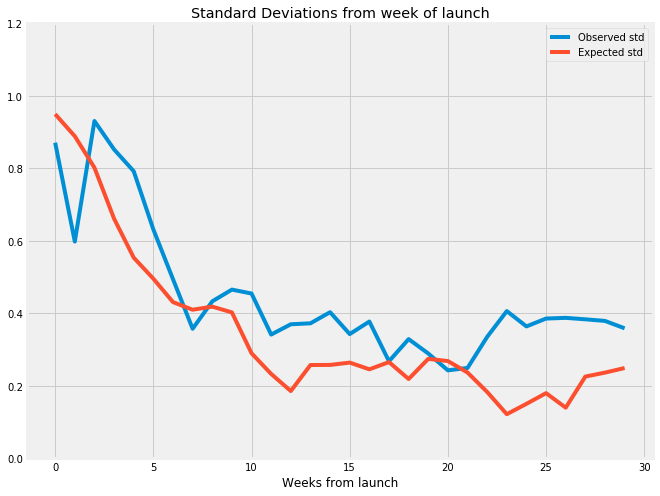

In [10]:
all_firms = df.firm.unique()
firm_lengths_ = np.empty(len(all_firms) + 1, dtype=int)
firm_lengths_[0] = 0
for i, firm_i in enumerate(all_firms):
    firm_lengths_[i + 1] = df[df.firm == firm_i].index[-1] + 1

    
lambdas0 = src.from_theta_to_lambda_for_all_firms(optθ, xs, prior_shocks)

dmd_const_dict = param_array_to_dmd_constants(optΞ)
γ, beta_shock_std = dmd_const_dict['γ'], dmd_const_dict['beta_shock_std']
taste_shock_std = dmd_const_dict['taste_shock_std']

# Redo taste_shocks and b0
taste_shocks_ = taste_std_normal_shocks*taste_shock_std
b0_ = np.clip(src.const.mature_beta + beta_shock_std*b0_std_normal_shocks, -np.inf, -1.05)


exp_prices = []
m_betas_inertia = inner_loop_with_numba_unbalanced(simul_repetitions, firm_lengths_,
                                                  n_firms, len(df), γ,
                                                  taste_shocks_, b0_)

for m in range(simul_repetitions):
    df['betas_inertia'] = m_betas_inertia[:, m]
    mean_std_observed_prices_clean, mean_std_expected_prices = (
            src.get_intersection_of_observed_and_expected_prices(
                                mean_std_observed_prices, df, policyF, lambdas0, min_periods))
    exp_prices.append(mean_std_expected_prices)

try:
    assert len(mean_std_observed_prices_clean) == len(mean_std_expected_prices)
except AssertionError as e:
    e.args += (len(mean_std_observed_prices_clean), len(mean_std_expected_prices))
    raise
exp_prices_df = pd.concat(exp_prices, axis=1)
mean_std_expected_prices = exp_prices_df.mean(axis=1)

max_t = max_t_to_consider
mean_std_observed_prices_clean = mean_std_observed_prices_clean.values[:max_t]
mean_std_expected_prices = mean_std_expected_prices.values[:max_t]



fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
max_index = 30
ind_t = range(len(mean_std_expected_prices))
ax1.plot(ind_t[0:max_index], mean_std_observed_prices_clean[0:max_index],
         label="Observed std")
#ax1.plot(ind_t, mean_std_expected_prices, label="Expected std")
ax1.plot(ind_t[0:max_index], mean_std_expected_prices[0:max_index], label="Expected std")
ax1.legend()
ax1.set_ylim(0, 1.2)
ax1.set_title("Standard Deviations from week of launch")
ax1.set_xlabel("Weeks from launch")
#ax2.plot(mean_std_observed_prices.index, mean_std_observed_prices, label="Original observed std")
#ax2.legend()

In [15]:
cleaned_data = "../../../firm_learning/data/cleaned_data/"

df = pd.read_csv(cleaned_data + "medium_prod_for_gmm.csv")

In [16]:
df.head(3)

,Unnamed: 0,level_prices,log_dmd,t,per_firm_t,firm,xs,rolling_std_upc
0,0,12.99,1.098612,1.0,1.0,222577,8500.91,1.173319e-07
1,1,12.99,0.000000,2.0,2.0,222577,8500.91,1.173319e-07
2,2,12.99,2.197225,3.0,3.0,222577,8500.91,1.173319e-07


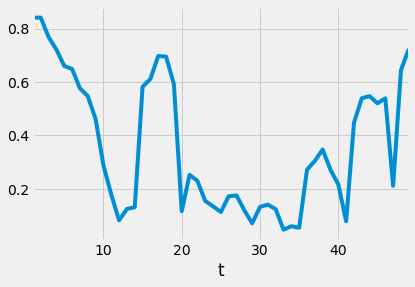

In [29]:
df.groupby('t').rolling_std_upc.mean().plot()

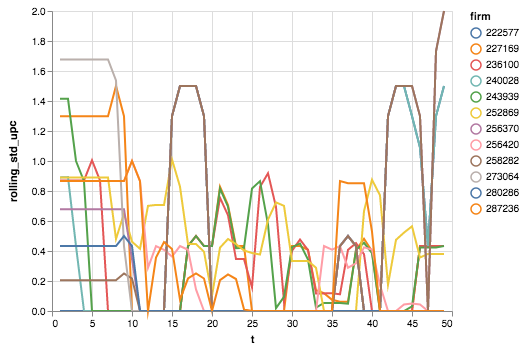

In [26]:
import altair as alt
alt.Chart(df).mark_line().encode(
    x='t',
    y='rolling_std_upc',
    color='firm:N'
)

Text(0.5, 1.0, 'Eβ')

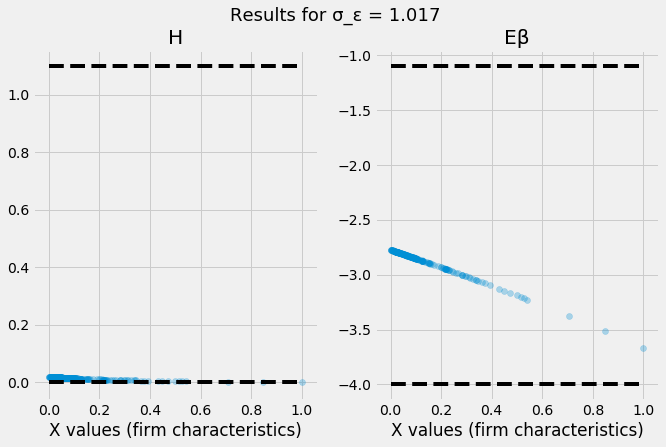

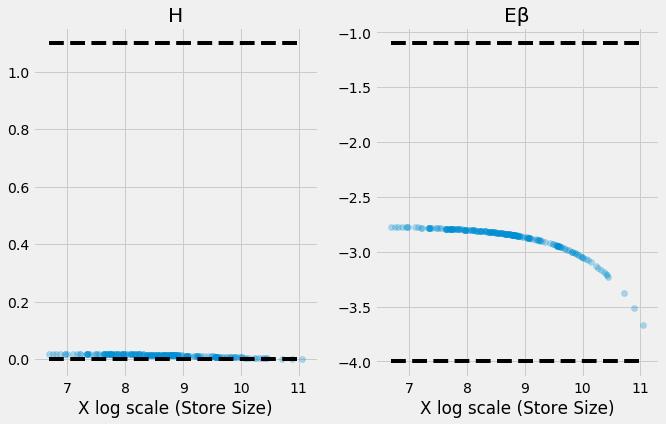

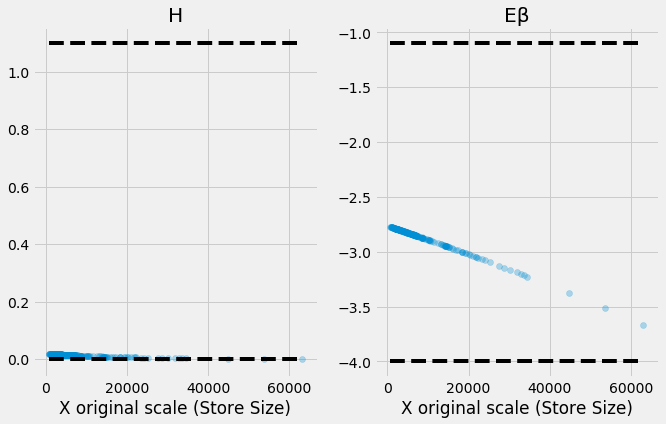

In [4]:

#Obtained results
#Old: θ = np.array([-0.53, -0.26,  0.52, -0.34])
#θ = np.array([-3.86, -4.4,   1.05,  0.1 ]) #for delta = 0.95
θ = np.array([-3.95, -3.62,  1.02,  0.28])
H = np.e**((θ[0] + θ[1]*xs + prior_shocks))
Eβ = -np.e**(θ[2] + θ[3]*xs + prior_shocks)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
ax1.set_xlabel("X values (firm characteristics)")
ax2.set_xlabel("X values (firm characteristics)")

ax1.scatter(xs, H, alpha=0.3)
ax1.set_title("H")
max_H_value = np.log(3)
ax1.hlines(0., xs.min(), xs.max(), linestyles="dashed")
ax1.hlines(max_H_value, xs.min(), xs.max(), linestyles="dashed")
ax2.scatter(xs, Eβ, alpha=0.3)
ax2.hlines(src.betas_transition.min(), xs.min(), xs.max(), linestyles="dashed")
ax2.hlines(src.betas_transition.max(), xs.min(), xs.max(), linestyles="dashed")
ax2.set_title("Eβ")
fig.suptitle("Results for σ_ɛ = 1.017", size=18)

#Plot over log Xs
orig_x = np.log(df.groupby('firm').xs.first().values) #log this?
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
ax1.set_xlabel("X log scale (Store Size)")
ax2.set_xlabel("X log scale (Store Size)")

ax1.scatter(orig_x, H, alpha=0.3)
ax1.set_title("H")
max_H_value = np.log(3)
ax1.hlines(0., orig_x.min(), orig_x.max(), linestyles="dashed")
ax1.hlines(max_H_value, orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.scatter(orig_x, Eβ, alpha=0.3)
ax2.hlines(src.betas_transition.min(), orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.hlines(src.betas_transition.max(), orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.set_title("Eβ")

#Plot over original Xs
orig_x = (df.groupby('firm').xs.first().values) #log this?
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
ax1.set_xlabel("X original scale (Store Size)")
ax2.set_xlabel("X original scale (Store Size)")

ax1.scatter(orig_x, H, alpha=0.3)
ax1.set_title("H")
max_H_value = np.log(3)
ax1.hlines(0., orig_x.min(), orig_x.max(), linestyles="dashed")
ax1.hlines(max_H_value, orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.scatter(orig_x, Eβ, alpha=0.3)
ax2.hlines(src.betas_transition.min(), orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.hlines(src.betas_transition.max(), orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.set_title("Eβ")


Text(0.5, 1.0, 'E[dmd elasticity] at launch')

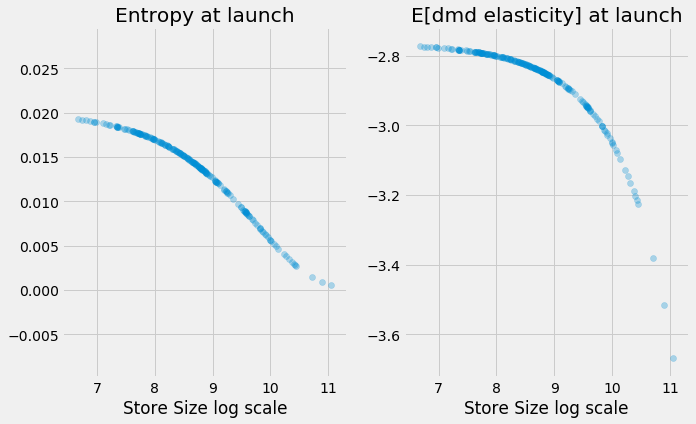

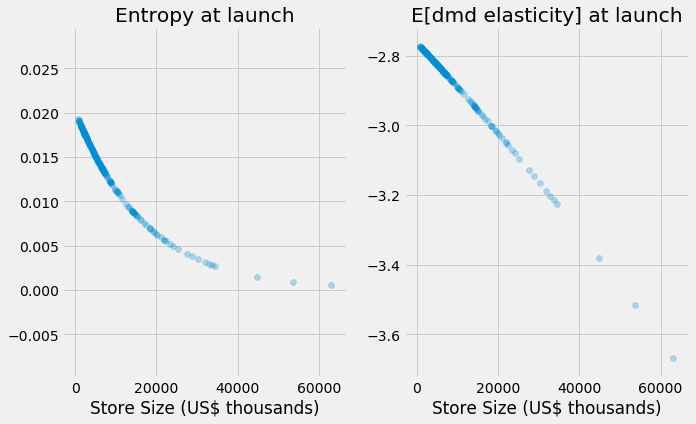

In [5]:
#θ = [-3.84, -2.98,  0.85,  0.55] #delta 0.99. Convergió
#θ = np.array([-3.98, -0.29,  1.05, -0.17])  #esta está ok
H = np.e**((θ[0] + θ[1]*xs + prior_shocks))
Eβ = -np.e**(θ[2] + θ[3]*xs + prior_shocks)

#Plot over log Xs
orig_x = np.log(df.groupby('firm').xs.first().values) 
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
ax1.set_xlabel("Store Size log scale")
ax2.set_xlabel("Store Size log scale")

ax1.scatter(orig_x, H, alpha=0.3)
ax1.set_title("Entropy at launch")
ax2.scatter(orig_x, Eβ, alpha=0.3)
ax2.set_title("E[dmd elasticity] at launch")

#Plot over original Xs
orig_x = (df.groupby('firm').xs.first().values) 
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
ax1.set_xlabel("Store Size (US$ thousands)")
ax2.set_xlabel("Store Size (US$ thousands)")

ax1.scatter(orig_x, H, alpha=0.3)
ax1.set_title("Entropy at launch")
ax2.scatter(orig_x, Eβ, alpha=0.3)
ax2.set_title("E[dmd elasticity] at launch")

## Plot gmm as a function of parameters

Done with plot 0
Done with plot 1
Done with plot 2
Done with plot 3


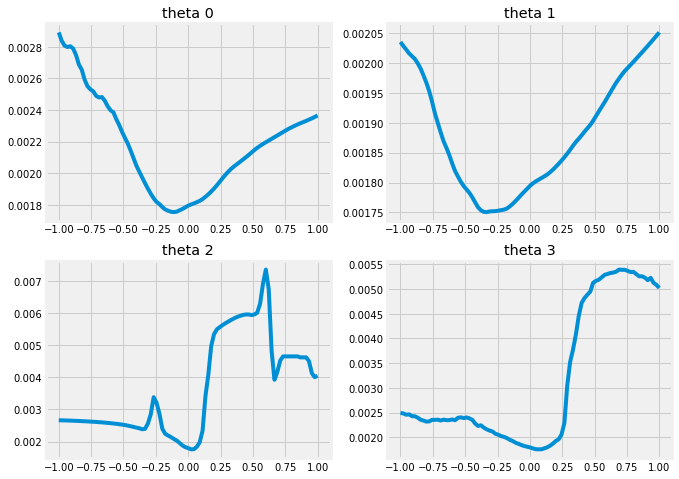

In [6]:
prior_shocks = src.gen_prior_shocks(Nfirms, σerror=0)


# Optimization
######################
def error_w_data(θ) -> float:
    return src.gmm_error(θ, policyF, xs,
                         mean_std_observed_prices=mean_std_observed_prices, df=df,
                         prior_shocks=prior_shocks, min_periods=min_periods)


def error_w_data_vector(θ_vector) -> float:
    error_vector = np.empty(len(θ_vector))
    for i, theta in enumerate(θ_vector):
        error_vector[i] = error_w_data(theta)
    return error_vector

optθ = np.array([-3.98, -0.29,  1.05, -0.17])

#Move each parameter by 30%
def domain_move_param(x, n_reps, perc=0.3):
    #return np.linspace(-perc*x, +perc*x, n_reps)
    return np.linspace(-1., 1., n_reps)

def move_one_parameter(optθ, n_reps, ind_to_change):
    repeated_res = np.repeat([optθ], n_reps, axis=0)
    movements = domain_move_param(optθ[ind_to_change], n_reps)
    for i in range(n_reps):
        repeated_res[i, ind_to_change] += movements[i]
    return repeated_res

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax0, ax1, ax2, ax3 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
n_reps = 91

for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(domain_move_param(optθ[i], n_reps), 
             error_w_data_vector(move_one_parameter(optθ, n_reps, i)))
    ax.set_title(f"theta {i}")
    print(f"Done with plot {i}")

#error_w_data(θ)

Text(0.5, 0, 'Weeks from launch')

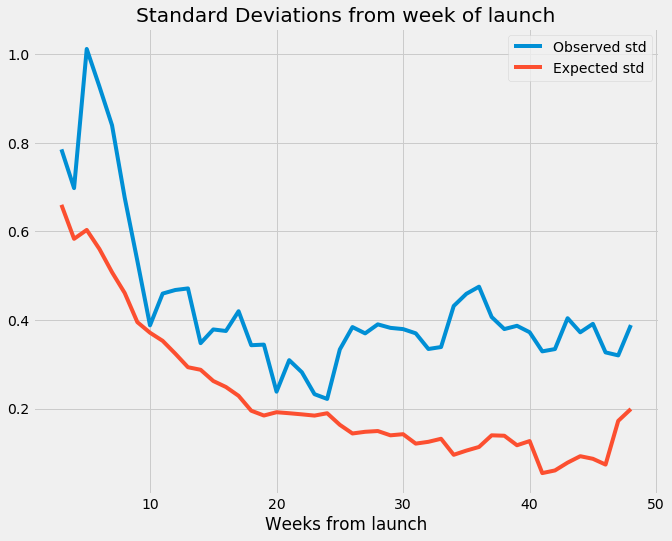

In [74]:
exp_prices_df = pd.concat(exp_prices, axis=1)

In [76]:
mean_std_expected_prices

t
3.0     2.655838e-01
4.0     1.230172e-01
5.0     2.407776e-01
6.0     2.978718e-01
7.0     4.022344e-01
8.0     3.835750e-01
9.0     3.686956e-01
10.0    2.916389e-01
11.0    2.732699e-01
12.0    3.068517e-01
13.0    3.613458e-01
14.0    3.529895e-01
15.0    2.540195e-01
16.0    1.387606e-01
17.0    1.442747e-01
18.0    1.502605e-01
19.0    1.912524e-01
20.0    2.275950e-01
21.0    2.024678e-01
22.0    1.656415e-01
23.0    1.260352e-01
24.0    1.086147e-01
25.0    1.218847e-01
26.0    1.262262e-01
27.0    1.201503e-01
28.0    7.606026e-02
29.0    1.268427e-01
30.0    1.196983e-01
31.0    8.075261e-02
32.0    3.917239e-02
33.0    9.033630e-02
34.0    1.123208e-01
35.0    2.040638e-01
36.0    1.414748e-01
37.0    1.024800e-01
38.0    1.085820e-02
39.0    4.998857e-08
40.0    5.237308e-08
41.0    8.128420e-09
42.0    1.469403e-10
43.0    2.154609e-10
44.0    1.815166e-10
45.0    1.323137e-09
46.0    3.232597e-08
47.0    1.295922e-07
48.0    0.000000e+00
Name: std_dev_prices, dtype: flo

In [75]:
exp_prices_df.mean(axis=1)

t
3.0     0.255009
4.0     0.108720
5.0     0.216105
6.0     0.298061
7.0     0.339898
8.0     0.367785
9.0     0.362450
10.0    0.339508
11.0    0.317118
12.0    0.302265
13.0    0.298481
14.0    0.287567
15.0    0.262619
16.0    0.231872
17.0    0.229701
18.0    0.208099
19.0    0.199999
20.0    0.193018
21.0    0.180633
22.0    0.173839
23.0    0.165312
24.0    0.168991
25.0    0.156178
26.0    0.137912
27.0    0.127809
28.0    0.119780
29.0    0.119822
30.0    0.120935
31.0    0.118631
32.0    0.114044
33.0    0.112680
34.0    0.117476
35.0    0.134124
36.0    0.137406
37.0    0.120371
38.0    0.080657
39.0    0.095342
40.0    0.064012
41.0    0.011592
42.0    0.057921
43.0    0.055143
44.0    0.049586
45.0    0.010017
46.0    0.000830
47.0    0.058199
48.0    0.000000
dtype: float64

## Fix deep parameters, but optimize over demand ones

In [71]:
t = len(mean_std_expected_prices)
w = np.identity(t)
g = (1 / t) * (mean_std_expected_prices.values - mean_std_observed_prices_clean.values)
g.T @ w @ g


0.001117008914783687

In [67]:
np.random.seed(28728)
optθ = θ
lambdas0 = src.from_theta_to_lambda_for_all_firms(optθ, xs, prior_shocks)

def param_array_to_dmd_constants(Ξ):
    return {'γ': Ξ[0],  'beta_shock_std': Ξ[1], 'taste_shock_std': Ξ[2]}

optimization_limits = [(0.5, 0.9), (0.1, 0.5), (0.3, 0.8)]

@njit()
def generate_betas_inertia_Ξ(γ: int, taste_shocks_: np.array, b0_: np.array, 
                             firm_periods: int, i_firm: int) -> np.array:
    """
    Generates the vector of beta demands for a firm for a total of t periods
    given by the parameter firm_periods

    :param firm_periods:
    :param i_firm:
    :return:
    """  
    betas = np.empty(firm_periods)
    betas[0] = b0_[i_firm]
    old_beta = b0_[i_firm]
    for t_ in range(1, firm_periods):
        new_beta = src.nb_clip(γ * old_beta + taste_shocks_[t_, i_firm], -np.inf, -1.05)
        betas[t_] = new_beta
        old_beta = new_beta

    return betas    
    

def error_w_data(Ξ) -> float:
    dmd_const_dict = param_array_to_dmd_constants(Ξ)
    γ, beta_shock_std = dmd_const_dict['γ'], dmd_const_dict['beta_shock_std']
    taste_shock_std = dmd_const_dict['taste_shock_std']
    
    # Redo taste_shocks and b0
    taste_shocks_ = np.random.normal(loc=0, scale=taste_shock_std,
                                size=(max_t_periods_in_data, n_firms))
    b0_ = np.clip(np.random.normal(loc=src.const.mature_beta,
                                  scale=beta_shock_std, size=n_firms),
                                 -np.inf, -1.05)
    
    df["betas_inertia"] = 0.
    #TODO: jit this for loop
    for i_firm, firm in enumerate(df.firm.unique()):
        mask: pd.Series = (df.firm == firm)
        t = mask.sum()
        df.loc[mask, "betas_inertia"] = generate_betas_inertia_Ξ(γ, taste_shocks_,
                                                                b0_, t, i_firm)
        
    mean_std_observed_prices_clean, mean_std_expected_prices = src.get_intersection_of_observed_and_expected_prices(
                 mean_std_observed_prices, df, policyF, lambdas0, 3)
    max_t = 37
    mean_std_observed_prices_clean = mean_std_observed_prices_clean[:max_t]
    mean_std_expected_prices = mean_std_expected_prices[:max_t]
    t = len(mean_std_expected_prices)
    w = np.identity(t)
    #TODO: simplify this. Pass to values,  no need for np.newaxis
    #g = (1 / t) * (mean_std_expected_prices - mean_std_observed_prices_clean)[:, np.newaxis]
    #return (g.T @ w @ g)[0, 0]
    g = (1 / t) * (mean_std_expected_prices.values - mean_std_observed_prices_clean.values)
    return (g.T @ w @ g)

maxiters = 100
start = time.time()
optimi = opt.differential_evolution(error_w_data, optimization_limits,
                                    maxiter=maxiters)
time_taken = time.time()/60 - start/60
print("Taken {0} minutes for {1} iterations. {2} per iteration".format(
      time_taken, maxiters, time_taken/maxiters))

print("Success: ", optimi.success)
print("Optimizados: ", np.round(optimi.x, 2))

Taken 89.10587258264422 minutes for 100 iterations. 0.8910587258264422 per iteration
Success:  False
Optimizados:  [0.82 0.41 0.75]


Text(0.5, 0, 'Weeks from launch')

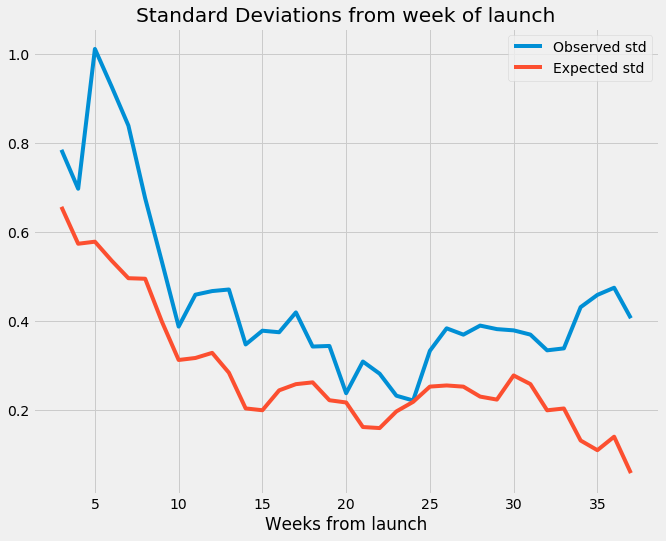

In [68]:
Ξ = optimi.x

dmd_const_dict = param_array_to_dmd_constants(Ξ)
γ, beta_shock_std = dmd_const_dict['γ'], dmd_const_dict['beta_shock_std']
taste_shock_std = dmd_const_dict['taste_shock_std']

def generate_betas_inertia_Ξ(time_periods: int) -> np.ndarray:
    """
    Generate an array of beta_inertia values for t time periods
    """
    betas = np.empty(time_periods)
    taste_shocks = np.random.normal(loc=0, scale=taste_shock_std, size=time_periods)

    b0 = np.clip(np.random.normal(loc=src.const.mature_beta, scale=beta_shock_std), -np.inf, -1.05)
    betas[0] = b0
    old_beta = b0
    for t in range(1, time_periods):
        new_beta = np.clip(γ * old_beta + taste_shocks[t], -np.inf, -1.05)
        betas[t] = new_beta
        old_beta = new_beta

    return betas

for firm in df.firm.unique():
    mask: pd.Series = (df.firm == firm)
    t = mask.sum()
    df.loc[mask, "betas_inertia"] = generate_betas_inertia_Ξ(t)

mean_std_observed_prices_clean, mean_std_expected_prices = src.get_intersection_of_observed_and_expected_prices(
             mean_std_observed_prices, df, policyF, lambdas0, 3)

max_t = 37
mean_std_observed_prices_clean = mean_std_observed_prices_clean[:max_t]
mean_std_expected_prices = mean_std_expected_prices[:max_t]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
ind_t = mean_std_expected_prices.index
ax1.plot(ind_t, mean_std_observed_prices_clean, label="Observed std")
ax1.plot(ind_t, mean_std_expected_prices, label="Expected std")
ax1.legend()
ax1.set_title("Standard Deviations from week of launch")
ax1.set_xlabel("Weeks from launch")

In [17]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x):
    return x


interact(f, x=10)



10

<function __main__.f(x)>

## Plot Real vs Expected prices

In [ ]:


expected_prices = src.generate_pricing_decisions(policyF, lambda0, demand_obs,
                               dmd_shocks, use_real_dmd=False)


In [9]:
xs = (df.groupby('firm').xs.first().values + 0.1)
scaler = MinMaxScaler()
xs = scaler.fit_transform(xs.reshape(-1, 1)).flatten()

optθ = np.array([-3.98, -0.29,  1.05, -0.17])
lambdas_at_0 = src.from_theta_to_lambda_for_all_firms(optθ, xs, prior_shocks)

pricing_decision_dfs = []
for i, firm in enumerate(df.firm.unique()):
    prices = src.generate_pricing_decisions(policyF, lambdas_at_0[i],
                                            df[df.firm == firm].log_dmd.values,
                                            df[df.firm == firm].dmd_shocks.values)
    pricing_decision_dfs.append(pd.DataFrame({'level_prices': prices,
                                              'firm': np.repeat(firm, len(prices))
                                              }))

pricing_decision_df = pd.concat(pricing_decision_dfs, axis=0)

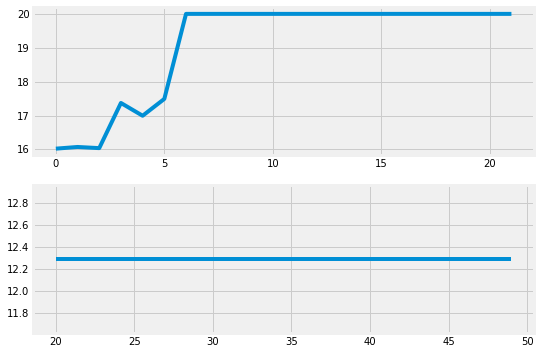

In [55]:
firms = df.firm.unique()
firm_i = firms[99]
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(pricing_decision_df[pricing_decision_df.firm==firm_i].index,
       pricing_decision_df[pricing_decision_df.firm==firm_i].level_prices)
ax2.plot(df[df.firm==firm_i].t, df[df.firm==firm_i].level_prices)

## Fix generation of expected moments to match trasnformation done to real data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import dill
import pandas as pd
from scipy import optimize as opt
from sklearn.preprocessing import MinMaxScaler
import time
import sys
sys.path.append('../../')
import src

maxiters = 100 #1.2 minutos por iteración
time_periods = 40 #Maximum spell_t to consider
min_periods = 3 #Min window period for standard deviation
use_logs_for_x = False

file_n = "2019-4-28medium_prod_vfi_dict.dill"
#file_n = "" #Work Macbook
with open('../../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)

cleaned_data = "../../../firm_learning/data/cleaned_data/"

df = pd.read_csv(cleaned_data + "medium_prod_for_gmm.csv")
std_devs = (df.groupby('firm').level_prices.rolling(window=4, min=min_periods)
            .std().reset_index()
            .rename(columns={'level_1': 't', 'level_prices': 'std_dev_prices'}))

df = pd.merge(df, std_devs, on=['firm', 't'], how='left')
df["dmd_shocks"] = np.random.normal(loc=0, scale=src.const.σ_ɛ, size=len(df))
df["betas_inertia"] = 0.
for firm in df.firm.unique():
    mask: pd.Series = (df.firm == firm)
    t = mask.sum()
    df.loc[mask, "betas_inertia"] = src.generate_betas_inertia(t)
#mean_std_observed_prices = df.groupby('t').std_dev_prices.mean()[min_periods:]
mean_std_observed_prices = df.groupby('t').rolling_std_upc.mean()[min_periods:]


In [3]:
pricing_decision_dfs = []
for i, firm in enumerate(df.firm.unique()):
    prices = src.generate_pricing_decisions(policyF, lambdas_at_0[i],
                                        df[df.firm == firm].log_dmd.values,
                                        df[df.firm == firm].dmd_shocks.values,
                                        df[df.firm == firm].betas_inertia.values)
    pricing_decision_dfs.append(pd.DataFrame({'level_prices': prices,
                                              'firm': np.repeat(firm, len(prices))
                                              }))

pricing_decision_df = pd.concat(pricing_decision_dfs, axis=0)

NameError: name 'lambdas_at_0' is not defined